# Trabalho Prático I - Problema de Transporte de Objeto 

**FURB - Data Science - Turma 02**<br>
**Disciplina:** Reinforcement Learning<br>
**Aluno:** Felipe Eduardo Gomes <br>

---
Baseado no projeto: https://github.com/michaeltinsley/Gridworld-with-Q-Learning-Reinforcement-Learning-/blob/master/Gridworld.ipynb


### Imports de biblioteca

In [8]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
class GridWorld:
    ## Inicializar dados iniciais
    def __init__(self):
        # Definir informações sobre o mundo da grade
        self.height = 6
        self.width = 7
        self.grid = np.zeros(( self.height, self.width)) - 1
        
        # Definir local de início conforme imagem
        self.current_location = (5,0)

        # Defina locais para as paredes, base e obj
        self.parede_location = [(4,0), (4,1), (4,3), (4,4), (4,5), (4,6), (5,6), (1,3)]
        self.base_location = [(0,2), (0,3), (0,4)]
        self.obj_location = (2,3)

        self.terminal_states = [self.base_location]

        # Defina recompensas de grade para células especiais
        self.grid[self.obj_location[0], self.obj_location[1]] = 10
        self.grid[self.base_location[0][0], self.base_location[0][1]] = 5
        self.grid[self.base_location[1][0], self.base_location[1][1]] = 5
        self.grid[self.base_location[2][0], self.base_location[2][1]] = 5
        
        # Definir ações disponíveis
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'STOP']
    
        
    def get_available_actions(self):
      "" "Retorna ações possíveis" ""
      return self.actions
       
            
    def agent_on_map(self):
        "" "Imprime a localização atual do agente na grade (usado para depuração)" ""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        grid[ self.parede_location[0]] = -2
        grid[ self.parede_location[1]] = -2
        grid[ self.parede_location[2]] = -2
        grid[ self.parede_location[3]] = -2
        grid[ self.parede_location[4]] = -2
        grid[ self.parede_location[5]] = -2
        grid[ self.parede_location[6]] = -2
        grid[ self.parede_location[7]] = -2
        grid[ self.base_location[0]] = 5
        grid[ self.base_location[1]] = 5
        grid[ self.base_location[2]] = 5
        grid[ self.obj_location[0], self.obj_location[1]] = 10
        return grid
    
    def get_reward(self, new_location):
      "" "Retorna a recompensa por uma posição de entrada" ""
      return self.grid[ new_location[0], new_location[1]]
              
        
    
    def make_step(self, action):
        """Move o agente na direção especificada. Se o agente está na fronteira, o agente fica parado
        mas recebe recompensa negativa. A função retorna a recompensa pelo movimento."""
        # Armazenar localização anterior
        last_location = self.current_location
        
        # UP
        if action == 'UP':
            # Se o agente estiver no topo, fique parado, receba a recompensa
            if last_location[0] == 0: #0 é o topo. Começa de cima para baixo. Nosso agente começa no 5
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                if self.current_location in self.parede_location or self.current_location == self.obj_location: #se a nova localização for uma parede fica parado senão assume a nova localização, ou se a nova posição for 2,3 porém pela ação UP desconsidera o movimento.
                  self.current_location = last_location
                  reward = -2 
                else:
                  reward = self.get_reward(self.current_location)
        
        # DOWN
        elif action == 'DOWN':
            # Se o agente estiver no fundo, fique parado, receba a recompensa
            if last_location[0] == self.height - 1: #se estive no fundo (5) ou seja, se a localização na posição 0 for o tamanho do grid - 1 permanece parado.
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                if self.current_location in self.parede_location: #se a nova localização for uma parede fica parado senão assume a nova localização
                  self.current_location = last_location
                  reward = -2 
                else:
                  reward = self.get_reward(self.current_location)
            
        # LEFT
        elif action == 'LEFT':
            # Se o agente estiver à esquerda, fique parado, colete a recompensa
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                if self.current_location in self.parede_location: #se a nova localização for uma parede fica parado senão assume a nova localização
                  self.current_location = last_location
                  reward = -2 
                else:
                  reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # Se o agente estiver à direita, fique parado, receba a recompensa
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                if self.current_location in self.parede_location: #se a nova localização for uma parede fica parado senão assume a nova localização
                  self.current_location = last_location
                  reward = -2 
                else:
                  reward = self.get_reward(self.current_location)
        
        # STOP
        elif action == 'STOP':
            # Se STOP, fique parado
            reward = self.get_reward(last_location)
                
        return reward
    
    def check_state(self):
        """Verifique se o agente está em um estado terminal (ouro ou bomba), em caso afirmativo, retorne 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [13]:
class RandomAgent():        
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [10]:
class Q_Agent():
    # Inicializar
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Armazene todos os valores Q no dicionário de dicionários 
        for x in range(environment.height): # Faça um loop por todos os espaços de grade possíveis, crie um subdicionário para cada
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0, 'STOP':0} # Preencher subdicionário com valores zero para possíveis movimentos

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def choose_action(self, available_actions):
        """Retorna a ação ideal da tabela Q-Value. Se houver várias ações ótimas, escolhe a escolha aleatória.
        Tornará uma ação aleatória exploratória dependente do épsilon."""
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_location]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action
    
    def learn(self, old_state, reward, new_state, action):
        """Atualiza a tabela de valor Q usando Q-learning"""
        q_values_of_state = self.q_table[new_state]
        max_q_value_in_new_state = max(q_values_of_state.values())
        current_q_value = self.q_table[old_state][action]
        
        self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)

In [11]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """A função play executa iterações e atualiza os valores Q, se desejado."""
    reward_per_episode = [] # Inicializar registro de desempenho
    
    for trial in range(trials): # Faça testes
        cumulative_reward = 0 # Inicializar os valores de cada jogo
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Corra até o máximo de passos ou até que o jogo termine
            old_state = environment.current_location
            action = agent.choose_action(environment.actions) 
            reward = environment.make_step(action)
            new_state = environment.current_location
            
            
            if learn == True: # Atualize os valores Q se o aprendizado for especificado
                agent.learn(old_state, reward, new_state, action)
                
            cumulative_reward += reward
            step += 1
            
            if environment.check_state() == 'TERMINAL': # Se o jogo estiver em estado terminal, termina o jogo e inicia a próxima avaliação
                environment.__init__()
                game_over = True     
                
        reward_per_episode.append(cumulative_reward) # Anexar recompensa para o teste atual ao registro de desempenho
        
    return reward_per_episode # Retornar log de desempenho

### Executar o agente aleatório, sendo que o mesmo move alaeatoriamente e não aprende com suas ações. Para efeitos de comparação com o agente Q-Learning.

In [14]:
env = GridWorld()
agent = RandomAgent()

print("Posição atual do agente =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Ações disponíveis =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Ação escolhida aleatoriamente =", chosen_action)
reward = env.make_step(chosen_action)
print("Recompensa obtida =", reward)
print("Posição atual do agente =", env.current_location)
print(env.agent_on_map())

Posição atual do agente = (5, 0)
[[ 0.  0.  5.  5.  5.  0.  0.]
 [ 0.  0.  0. -2.  0.  0.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [-2. -2.  0. -2. -2. -2. -2.]
 [ 1.  0.  0.  0.  0.  0. -2.]]
Ações disponíveis = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'STOP']
Ação escolhida aleatoriamente = DOWN
Recompensa obtida = -1.0
Posição atual do agente = (5, 0)
[[ 0.  0.  5.  5.  5.  0.  0.]
 [ 0.  0.  0. -2.  0.  0.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [-2. -2.  0. -2. -2. -2. -2.]
 [ 1.  0.  0.  0.  0.  0. -2.]]


### Executar o agente aleatório por 500 tentativas

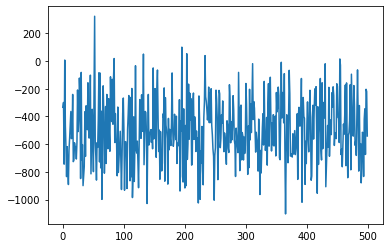

In [18]:
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

### Executar o agente Q-Learning por 500 tentativas

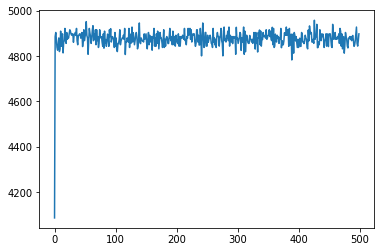

In [15]:
environment = GridWorld()
agentQ = Q_Agent(environment)

reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Curva de aprendizado simples
plt.plot(reward_per_episode)

### Imprimir a tabela final de valor Q

In [16]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.1
	DOWN
		5.50821175469987
	LEFT
		-0.1
	RIGHT
		188712.2601691454
	STOP
		-0.1
(0, 1)
	UP
		166067.03656330984
	DOWN
		168920.70591186103
	LEFT
		146173.80367144052
	RIGHT
		232193.9642036329
	STOP
		176261.6504850656
(0, 2)
	UP
		232191.24977124645
	DOWN
		231771.4345017332
	LEFT
		231714.60607829993
	RIGHT
		231684.56075080467
	STOP
		232739.50000215354
(0, 3)
	UP
		187365.27205904922
	DOWN
		182849.16533803008
	LEFT
		232241.2301428249
	RIGHT
		153387.91993803185
	STOP
		181689.70152798377
(0, 4)
	UP
		0
	DOWN
		-0.1
	LEFT
		194284.69999994707
	RIGHT
		0
	STOP
		0
(0, 5)
	UP
		-0.1
	DOWN
		0
	LEFT
		0.5
	RIGHT
		-0.1
	STOP
		-0.1
(0, 6)
	UP
		0
	DOWN
		-0.1
	LEFT
		-0.1
	RIGHT
		-0.1
	STOP
		0
(1, 0)
	UP
		26113.6647517171
	DOWN
		-0.2
	LEFT
		-0.2
	RIGHT
		-0.2
	STOP
		-0.1
(1, 1)
	UP
		211210.79303665488
	DOWN
		-0.2
	LEFT
		1160.412631117585
	RIGHT
		-0.19
	STOP
		-0.1
(1, 2)
	UP
		232266.50907213963
	DOWN
		162686.664364996
	LEFT
		151421.15589539852
	RIGHT
		19